In [311]:
#Lib
import pandas as pd
from joblib import load
# agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
#Zips
import py7zr
#elbow point
%pip install kneed
from kneed import KneeLocator
# plots 
%pip install plotly
import plotly.express as px
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [312]:
with py7zr.SevenZipFile('../../../../data/telecom_churn_me/original_train.7z', mode='r') as z:
    z.extractall(path='original_train/')
with py7zr.SevenZipFile('../../../../data/telecom_churn_me/test/x_test.7z', mode='r') as z:
    z.extractall(path='x_test/')
with py7zr.SevenZipFile('../../../../data/telecom_churn_me/test/y_test.7z', mode='r') as z:
    z.extractall(path='y_test/')
with py7zr.SevenZipFile('../../../../data/telecom_churn_me/test/y_test.7z', mode='r') as z:
    z.extractall(path='y_test/')
with py7zr.SevenZipFile('../../../../data/telecom_churn_me/telecom_churn_me.7z', mode='r') as z:
    z.extractall(path='telecom_churn_me/')

In [313]:
target = 'TARGET'

In [314]:
train = pd.read_csv('./original_train/original_train.csv')

x_test = pd.read_csv('./x_test/x_test.csv')
y_test = pd.read_csv('./y_test/y_test.csv')

x_train = train.drop([target], axis=1)
y_train = pd.DataFrame(train[target])
original_data = pd.read_csv('./telecom_churn_me/telecom_churn_me.csv')

In [315]:
x_test.dtypes

PARTY_NATIONALITY            float64
BILL_AMOUNT                  float64
PAYMENT_TRANSACTIONS         float64
PARTY_REV                    float64
PREPAID_LINES                float64
OTHER_LINES                  float64
STATUS                       float64
MOUS_TO_LOCAL_MOBILES        float64
MOUS_FROM_LOCAL_MOBILES      float64
MOUS_TO_LOCAL_LANDLINES      float64
MOUS_FROM_LOCAL_LANDLINES    float64
MOUS_TO_INT_NUMBER           float64
MOUS_FROM_INT_NUMBER         float64
DATA_IN_BNDL                 float64
Years_stayed                 float64
dtype: object

In [316]:
model = load('../../joblibs/telecom_churn_me/model/classification-model-smote.joblib')
model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator LabelBinarizer from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator MLPClassifier from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50), max_iter=100,
              random_state=1)

In [317]:
y_pred_prob = model.predict_proba(x_test)
y_pred = model.predict(x_test)
y_pred

array([0., 0., 0., ..., 1., 0., 1.])

In [318]:
x_ones = x_train
x_ones[target] = y_train
x_ones = x_ones.loc[x_ones[target] == 1.0]
x_ones = x_ones.drop([target], axis=1)
#PREPAID_LINES
x_ones

,PARTY_NATIONALITY,BILL_AMOUNT,PAYMENT_TRANSACTIONS,PARTY_REV,PREPAID_LINES,OTHER_LINES,STATUS,MOUS_TO_LOCAL_MOBILES,MOUS_FROM_LOCAL_MOBILES,MOUS_TO_LOCAL_LANDLINES,MOUS_FROM_LOCAL_LANDLINES,MOUS_TO_INT_NUMBER,MOUS_FROM_INT_NUMBER,DATA_IN_BNDL,Years_stayed
20,-0.557334,0.837551,-0.474652,-0.057025,-0.372874,-0.114327,1.868853,-0.013544,-0.003320,0.231725,-0.263387,-0.446350,-0.192129,0.464650,-0.911906
34,2.044388,-0.562857,2.261594,-0.094471,0.148701,-0.114327,-0.220822,-0.297483,-0.381333,-0.064715,-0.283676,0.395377,-0.192129,-0.176878,-0.584267
56,-0.557334,-0.435923,-0.474652,-0.041069,-0.199016,0.012830,-0.220822,-0.132948,-0.432914,-0.172299,-0.301507,-0.446350,-0.192129,0.241001,-0.748087
98,-0.213711,-0.599559,-0.474652,-0.044413,0.322559,0.012830,-0.220822,0.149383,0.379659,-0.336268,-0.152862,-0.438573,-0.192129,-0.239810,-0.748087
114,-0.410067,-0.967882,-0.474652,-0.073431,-0.372874,0.012830,-0.220822,-0.430009,-0.432914,-0.445148,-0.301507,-0.446350,-0.192129,-0.312506,2.692123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798255,-0.557334,-0.468020,-0.474652,-0.022936,-0.199016,0.012830,-0.220822,-0.402918,-0.426826,-0.329009,-0.236100,-0.446350,-0.192129,-0.161849,-0.748087
798353,-0.557334,-0.131247,-0.474652,-0.088198,0.148701,-0.114327,-0.220822,-0.410959,-0.430573,-0.445148,-0.301507,-0.446350,-0.192129,0.135443,-0.748087
798367,2.044388,-0.770664,-0.474652,-0.098628,-0.199016,-0.114327,-0.220822,-0.335937,-0.278605,-0.362969,-0.177983,0.414861,-0.095231,-0.308725,-0.584267
798379,2.044388,-0.939709,0.893471,-0.078278,0.322559,0.012830,-0.220822,-0.424696,0.431793,-0.445148,1.554686,-0.212447,-0.192129,-0.254356,-0.911906


In [319]:
#Elbow point visualization graph
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import numpy as np
scaler = MinMaxScaler()
scaler.fit(x_ones)
X=scaler.transform(x_ones)
inertia = []
max_clusters = x_ones.shape[1] + 1
cluster_number = list(range(1, max_clusters))
for i in cluster_number:
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
fig = go.Figure(data=go.Scatter(x=np.arange(1,max_clusters),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,max_clusters],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
    ])

In [320]:
#calculation of number of clusters
kneedle = KneeLocator(cluster_number, inertia, S=1.0, curve="convex", direction="decreasing")
clusters_number = kneedle.knee
if (cluster_number != int):
    kneedle = KneeLocator(cluster_number, inertia, S=0.0, curve="convex", direction="decreasing")
    clusters_number = kneedle.knee
clusters_number

5

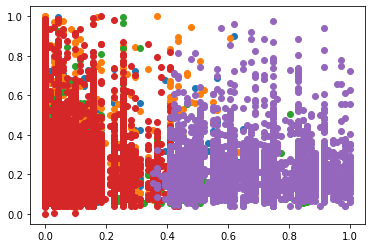

In [321]:
#K means 2D clusterization graph
model = KMeans(n_clusters=clusters_number)
# fit the model
model.fit(x_ones)
# assign a cluster to each example
yhat = model.predict(x_ones)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [322]:
#Focusing on churn clients
x_ones.reset_index
kmeans = KMeans(
        n_clusters=clusters_number, 
        init="k-means++",
        n_init=10,
        tol=1e-04, 
        random_state=42
    )
kmeans.fit(x_ones)
clusters=pd.DataFrame(x_ones)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
#Getting outliers
outliers = polar
upper = outliers['value'].quantile(0.97)
lower = outliers['value'].quantile(0.03)
outliers.groupby('variable').mean() 
outliers.loc[outliers['value'] < lower, 'outlier'] = True 
outliers.loc[outliers['value'] > upper, 'outlier'] = True 
outliers = outliers.dropna().set_index(['variable']).index
#Drop outliers
x_ones = x_ones.drop(columns=outliers).reset_index()
x_ones = x_ones.drop(columns=['index'])
x_ones



,BILL_AMOUNT,PAYMENT_TRANSACTIONS,PARTY_REV,PREPAID_LINES,OTHER_LINES,MOUS_TO_LOCAL_MOBILES,MOUS_FROM_LOCAL_MOBILES,MOUS_TO_LOCAL_LANDLINES,MOUS_FROM_LOCAL_LANDLINES,MOUS_TO_INT_NUMBER,MOUS_FROM_INT_NUMBER,DATA_IN_BNDL,label
0,0.837551,-0.474652,-0.057025,-0.372874,-0.114327,-0.013544,-0.003320,0.231725,-0.263387,-0.446350,-0.192129,0.464650,3
1,-0.562857,2.261594,-0.094471,0.148701,-0.114327,-0.297483,-0.381333,-0.064715,-0.283676,0.395377,-0.192129,-0.176878,1
2,-0.435923,-0.474652,-0.041069,-0.199016,0.012830,-0.132948,-0.432914,-0.172299,-0.301507,-0.446350,-0.192129,0.241001,2
3,-0.599559,-0.474652,-0.044413,0.322559,0.012830,0.149383,0.379659,-0.336268,-0.152862,-0.438573,-0.192129,-0.239810,2
4,-0.967882,-0.474652,-0.073431,-0.372874,0.012830,-0.430009,-0.432914,-0.445148,-0.301507,-0.446350,-0.192129,-0.312506,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41807,-0.468020,-0.474652,-0.022936,-0.199016,0.012830,-0.402918,-0.426826,-0.329009,-0.236100,-0.446350,-0.192129,-0.161849,2
41808,-0.131247,-0.474652,-0.088198,0.148701,-0.114327,-0.410959,-0.430573,-0.445148,-0.301507,-0.446350,-0.192129,0.135443,2
41809,-0.770664,-0.474652,-0.098628,-0.199016,-0.114327,-0.335937,-0.278605,-0.362969,-0.177983,0.414861,-0.095231,-0.308725,1
41810,-0.939709,0.893471,-0.078278,0.322559,0.012830,-0.424696,0.431793,-0.445148,1.554686,-0.212447,-0.192129,-0.254356,1


In [324]:
#Running clustering without outliers
kmeans = KMeans(
        n_clusters=clusters_number, 
        init="k-means++",
        n_init=10,
        tol=1e-04, 
        random_state=42
    )
kmeans.fit(x_ones)
clusters=pd.DataFrame(x_ones)
clusters['label']=kmeans.labels_
#Plotting results
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
#plotting clusters
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.update_layout(
   title="Churn profiles",
)
fig.show()

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future ve

In [325]:
#Pie plot to see clustering distribution
pie=clusters.groupby('label').size().reset_index()
pie.columns=['label','value']
px.pie(pie,values='value',names='label')